In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [26]:
cdfgeneric = dict({'A':0.4137 , 'tau1':0.9 , 'tau2':0.76, 'b':24 })

In [27]:
cdf64 = dict({'A':0.646 , 'tau1':0.433 , 'tau2':5.0, 'b':28 })

In [28]:
def SJK_CDF(cdfparam, t):
    A = cdfparam['A']
    b = cdfparam['b']
    tau1 = cdfparam['tau1']
    tau2 = cdfparam['tau2']
    return A*(1.0-np.exp(-t/tau1) + np.exp((t-b)/tau2))

def Expon_CDF(t):
    lamb = 1/24.0 
    return (1.0 - np.exp(-lamb*t))


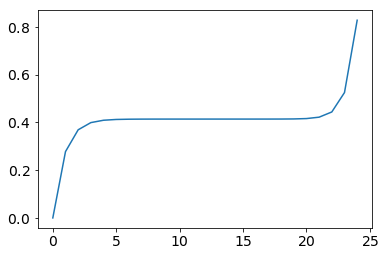

In [29]:
plt.plot([SJK_CDF(cdfgeneric, t) for t in np.arange(0,25)])

In [41]:
def job_fail_prob(cdf, job_len, start_time):
    p_fail = 0.0
    end_time = job_len + start_time 
    if end_time > 24.3:
        p_fail = 1.0 
        return p_fail 
    p_fail = SJK_CDF(cdf, end_time) - SJK_CDF(cdf, start_time)
    return p_fail 

In [42]:
def smart_job_fail_prob(cdf, job_len, start_time):
    p_fail = 0.0
    end_time = job_len + start_time 
    if end_time > 24.3:
        #start a new one for sure 
        p_fail_new = SJK_CDF(cdf, job_len) - SJK_CDF(cdf, 0)
        return p_fail_new
    else:
        p_fail_old = SJK_CDF(cdf, end_time) - SJK_CDF(cdf, start_time)
        p_fail_new = SJK_CDF(cdf, job_len) - SJK_CDF(cdf, 0)
        return min(p_fail_new, p_fail_old)

In [43]:
def wrong_model_fail_prob(wrongcdf, truecdf, job_len, start_time):
    
    p_fail = 0.0
    end_time = job_len + start_time 
    if end_time > 24.3:
        #start a new one for sure 
        p_fail_new = SJK_CDF(truecdf, job_len) - SJK_CDF(truecdf, 0)
        return p_fail_new
    
    #This is with the wrongcdf 
    p_fail_old = SJK_CDF(wrongcdf, end_time) - SJK_CDF(wrongcdf, start_time)
    p_fail_new = SJK_CDF(wrongcdf, job_len) - SJK_CDF(wrongcdf, 0)
    
    if p_fail_old <= p_fail_new:
        # We should continue on this server. Now get the true p_fail for THIS scenario
        true_p_fail = SJK_CDF(truecdf, end_time) - SJK_CDF(truecdf, start_time)
    else:
        # New server is better, whose fail prob would be...
        true_p_fail = SJK_CDF(truecdf, job_len) - SJK_CDF(truecdf, 0)
        
    return true_p_fail

In [34]:
wrong_model_fail_prob(cdfgeneric, cdf64, 4, 4)

0.006578325524684514

In [38]:
smart_job_fail_prob(cdf64, 4, 4)

0.006578325524684514

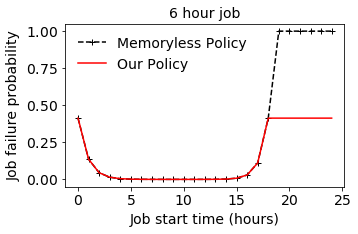

In [53]:
plt.plot([job_fail_prob(6,s) for s in range(0,25)], ls='--', color='k', marker='+', label="Memoryless Policy")
plt.plot([smart_job_fail_prob(6,s) for s in range(0,25)], color='r', label="Our Policy")
plt.legend(loc='best', frameon=False)
plt.xlabel("Job start time (hours)")
plt.ylabel("Job failure probability")
plt.title("6 hour job",fontsize=14)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 3)
plt.savefig("../graphs/Sched-bathtub.pdf",bbox_inches='tight')

In [39]:
def avg_fail_prob(cdf, job_len):
    return np.mean([job_fail_prob(cdf, job_len, s) for s in range(0,24)])

def smart_avg_fail_prob(cdf, job_len):
    return np.mean([smart_job_fail_prob(cdf, job_len, s) for s in range(0,24)])

def wrong_model_avg_fail_prob(wrongcdf, truecdf, job_len):
    return np.mean([wrong_model_fail_prob(wrongcdf, truecdf, job_len, s) for s in range(0,24)])

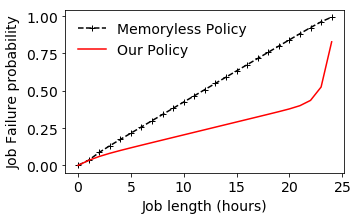

In [54]:
plt.plot([avg_fail_prob(job_len) for job_len in range(0,25)], ls='--', color='k', marker='+' , label="Memoryless Policy")
# The above is just the "True" fail probability 
plt.plot([smart_avg_fail_prob(job_len) for job_len in range(0,25)], color='r', label="Our Policy")
plt.legend(frameon=False)
plt.xlabel("Job length (hours)")
plt.ylabel("Job Failure probability")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 3)
plt.savefig("../graphs/Sched-fail-prob.pdf", bbox_inches='tight')

# Comparing Bathtub vs. Uniform CDF for expected job recomputation time

In [8]:
def exp_wasted(job_len, CDF_type):
    if CDF_type is "SJK":
        fail_prob = job_fail_prob_SJK(job_len, 0)
    else: 
        fail_prob = job_fail_prob_UNIFORM(job_len, 0)

    # We want \sum^joblen {P(x)*x}  
    
    return fail_prob


In [9]:
def job_fail_prob_SJK(job_len, start_time):
    p_fail = 0.0
    end_time = job_len + start_time 
    if end_time > 24.3:
        p_fail = 1.0 
        return p_fail 
    p_fail = SJK_CDF(end_time) - SJK_CDF(start_time)
    return p_fail 

In [10]:
def job_fail_prob_UNIFORM(job_len, start_time):
    p_fail = min(job_len/24.0, 1.0)
    return p_fail 

In [11]:
def wasted_UNIFORM(job_len):
    #Area of the triangle (0,0) (joblen,0) (joblen,CDF(joblen))
    #y = job_len/24.0 
    #return y * 0.5 * job_len 
    return job_len/2.0 #Wasted given there is a single failure 

In [12]:
wasted_UNIFORM(6)

3.0

In [13]:
def func_approx_4_param_expon_exp(t, A, b, tau1, tau2):
    return t*A*((np.exp(-t/tau1)/tau1) + (np.exp((t-b)/tau2))/tau2)    

In [14]:
def expected_paper(t):
    A = cdfparam['A']
    tau1 = cdfparam['tau1']
    tau2 = cdfparam['tau2']
    b = cdfparam['b']
    return -A*(t+tau1)*np.exp(-t/tau1) + A*(t-tau2)*np.exp((t-b)/tau2)

In [15]:
def wasted_SJK(job_len):
    return (expected_paper(job_len) - expected_paper(0))/SJK_CDF(job_len)

In [29]:
wasted_SJK(1)

0.40925827872289094

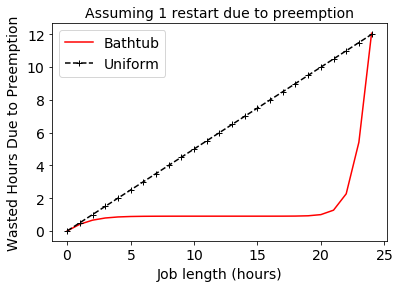

In [59]:
plt.plot([wasted_SJK(jlen) for jlen in range(0,25)], label="Bathtub", color='r')
plt.plot([wasted_UNIFORM(jlen) for jlen in range(0,25)], label="Uniform", ls='--', marker='+',  color='k')
plt.legend()
plt.xlabel("Job length (hours)")
plt.ylabel("Wasted Hours Due to Preemption")
plt.title("Assuming 1 restart due to preemption", fontsize=14)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)
plt.savefig("../graphs/uniform-v-bathtub.pdf", bbox_inches='tight')

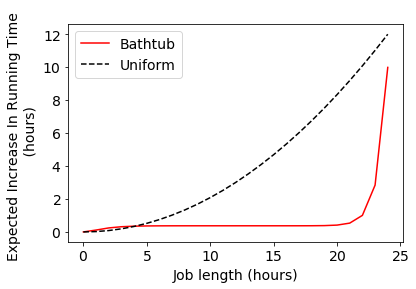

In [60]:
plt.plot([wasted_SJK(jlen)*job_fail_prob_SJK(jlen, 0) for jlen in range(0,25)], label="Bathtub", color='r')
plt.plot([wasted_UNIFORM(jlen)*job_fail_prob_UNIFORM(jlen,0) for jlen in range(0,25)], ls='--', label="Uniform", color='k')
plt.legend()
plt.xlabel("Job length (hours)")
plt.ylabel("Expected Increase In Running Time \n (hours)")
#plt.title("Waste*P(1 failure)")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)
plt.savefig("../graphs/uniform-v-bathtub-2.pdf", bbox_inches='tight')

# Want to compare generic vs. outlier CDF to estimate the impact on some policy. 

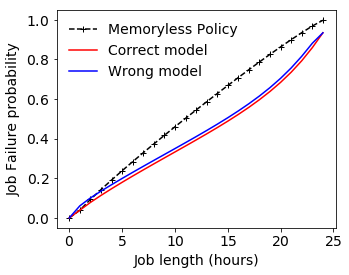

In [49]:
# This is for n64 with the wrong CDF .... 

plt.plot([avg_fail_prob(cdf64, job_len) for job_len in range(0,25)], ls='--', color='k', marker='+' , label="Memoryless Policy")
plt.plot([smart_avg_fail_prob(cdf64, job_len) for job_len in range(0,25)], color='r', label="Correct model")
plt.plot([wrong_model_avg_fail_prob(cdfgeneric, cdf64, job_len) for job_len in range(0,25)], color='b', label="Wrong model")

plt.legend(frameon=False)
plt.xlabel("Job length (hours)")
plt.ylabel("Job Failure probability")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 4)
plt.savefig("../graphs/wrong-model.pdf", bbox_inches='tight')